In [1]:
import numpy as np
from scipy.integrate import solve_bvp, solve_ivp
from matplotlib import pyplot as plt

# Create Model

In [50]:
class salt_lake():
    def __init__(self,k1, k2, params, tf,x0):
        """
        This function initializes the parameters for 
        our model
        parameters:
        -----------
        k1 (float): the first constant in the loss 
        function (multiplied by Q)
        k2 (float): the second constant in the loss 
        function (multipled by R)
        params (dict): a dictionary of the parameters used 
        in A and B
        tf (int): final time
        x0 (array): initial state
        """
        
        # Set Q
        self.Q = np.zeros((4,4))
        
        # Set A
        self.A = lambda t: np.array([[0,params['alpha'], -params['beta'], 0],
                        [params['epsilon'], 0, 0, params['lambda'](t)],
                        [params['delta'], 0, 0, params['gamma'](t)],
                         [0,0,0,0]])

        # Set R 
        self.R = k1
        
        #Set B 
        self.B = np.array([row, 0, 0, 0]).reshape(-1,1)
        
        # Set M
        M = np.zeros((4,4))
        M[0,0] = k2
        self.M = M
        
        # Set x0 and final time
        self.x0 = x0
        self.tf = tf
        
    def find_P(self):
        """
        Find the P used in LQR
        """

        # Define ricatti equation
        def ricatti(t,P):
            P = P.reshape((4,4))
            return (- P@self.A(t) - self.A(t).T@P - self.Q
                   + P@self.B*1/self.R*self.B.T@P).reshape(16)

        # Find P
        t_span = (self.tf,0)
        t_eval = np.linspace(self.tf, 0, self.tf+1)
        P0 = np.ones(16)
        sol = solve_ivp(ricatti, t_span, P0, t_eval=t_eval, dense_output=True)

        return sol.sol
    
    def find_state(self):
        """
        Solve for x
        """
        
        # Get P
        P = self.find_P()
        
        # Define ricatti equation
        def func(t,x):
            current_P = P(t).reshape((4,4))
            return self.A(t)@x - self.B*1/self.R*self.B.T@current_P@x

        # Find P
        t_span = (0,self.tf)
        t_eval = np.linspace(0, self.tf, self.tf+1)
        x0 = self.x0
        sol = solve_ivp(func, t_span, x0, t_eval=t_eval, dense_output=True)

        return sol.sol
    
    def find_control(self, t_vals):
        
        # Get P and x
        P = self.find_P()
        x = self.find_state()
        
        # Calculate u
        u = np.array([(-1/self.R*self.B.T@(P(t).reshape(4,4))@x(t))[0] for t in t_vals])
        
        return u
        
        
        
        

# Set parameters

In [72]:
# Set parameters
alpha = .75
beta = 1
epsilon = 0
delta = 0
row = 1
tf = 60
k1 = 1
k2 = 1

# Set functions
gamma = lambda t: 0
def lambda_(t):
    t = int(t)
    if t%12 == 1:
        return 0.1 #4.4
    elif t%12 == 2:
        return -1 #3.4
    elif t%12 == 3:
        return -1.2 #2.2
    elif t%12 == 4:
        return -0.3 #1.9
    elif t%12 == 5:
        return -0.2 #1.7
    elif t%12 == 6:
        return -0.8 #0.9
    elif t%12 == 7:
        return -0.4 #0.5
    elif t%12 == 8:
        return 0.2 #0.7
    elif t%12 == 9:
        return 0.5 #1.2
    elif t%12 == 10:
        return 0.3 #1.5
    elif t%12 == 11:
        return 0.9 #2.4
    elif t%12 == 0:
        return 1.9 #4.3

# Set x0
x0 = np.array([-128, 4.3, 20/3, 1])

# Create parameter dict
params = {'alpha': alpha, 'beta':beta, 'epsilon':epsilon,
         'delta': delta, 'row':row, 'gamma':gamma, 
         'lambda': lambda_}

    

# Solve for state and control

In [73]:
# Find state and control
sl = salt_lake(k1,k2,params,tf,x0)
x = sl.find_state()
t_vals = np.linspace(0, tf, tf+1)
x_vals = x(t_vals)
u = sl.find_control(t_vals)

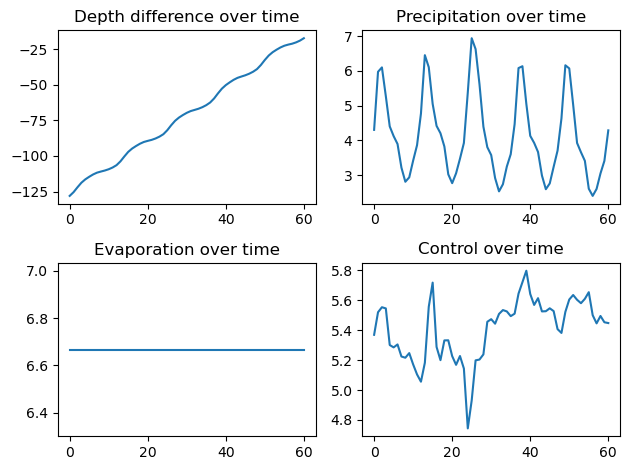

In [74]:
# Plot depth
plt.subplot(2,2,1)
plt.plot(t_vals, x_vals[0])
plt.title('Depth difference over time')

# Plot precipitation
plt.subplot(2,2,2)
plt.plot(t_vals, x_vals[1])
plt.title('Precipitation over time')

# Plot evaporation
plt.subplot(2,2,3)
plt.plot(t_vals, x_vals[2])
plt.title('Evaporation over time')

# Plot control
plt.subplot(2,2,4)
plt.plot(t_vals, u)
plt.title('Control over time')
plt.tight_layout()
plt.show()
